In [1]:
from tiff_processing_utils import tile_tiff_pair, tile_tiff_triplet, rasterize_shapefile
from sentinel_hub_utils import call_s2l2a_api
from MemoryMapDataset import MemmapDataset
import numpy as np
import psutil
import os
import gc

The processing pipeline assumes that the data in the Chunks folder is in the following format:
- Each chunk is in it's own folder and named 'Chunk x' or 'Chunk x x-x'
- The RGB tif should be named 'Chunkx.tif' or 'Chunkx_x-x.tif'
- label shape file and corresponding label files should be in a folder called 'labels' inside of the matching 'Chunk x' / 'Chunk x x-x' folder, the names of the files do not need to be formatted.

In [2]:
base_path = "one_meter_drone"

TILE_SIZE = 256

combined_drone_file = os.path.join(base_path, f'{TILE_SIZE}dataset_drone.npy')
combined_label_file = os.path.join(base_path, f'{TILE_SIZE}dataset_label.npy')
combined_satellite_file = os.path.join(base_path, f'{TILE_SIZE}dataset_satellite.npy')

# RAM thresholds
TOTAL_RAM_MB = psutil.virtual_memory().total / (1024 ** 2)
SAFE_RAM_USAGE_MB = TOTAL_RAM_MB - 16 * 1024  # 16GB below total RAM
CHUNK_BUFFER_SIZE = 5  # Number of chunks to keep in memory at a time

In [4]:
# convert all label shape files to tif and ping sentinel hub api to get satellite tifs
for entry in os.listdir(base_path):
    if 'Chunk' in entry:
        # create labels.tif
        chunk_path = os.path.join(base_path, entry)
        rasterized_shape = rasterize_shapefile(chunk_path)

        # create satellite.tif
        call_s2l2a_api(chunk_path)

print('\nDone')


Chunk 1 0-1 shapefile already rasterized
one_meter_drone/Chunk 1 0-1 epsg_code=32618
Querying SentinelHub API for Chunk 1 0-1
✅ TIFF file saved as 'one_meter_drone/Chunk 1 0-1/satellite.tif'

Chunk 1 0-0 shapefile already rasterized
one_meter_drone/Chunk 1 0-0 epsg_code=32618
Querying SentinelHub API for Chunk 1 0-0
✅ TIFF file saved as 'one_meter_drone/Chunk 1 0-0/satellite.tif'


Done


In [5]:
# Functions to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

In [7]:
"""
Convert all tif pairs into tiled datasets

NOTE: This will take a lot of time, memory, and storage space.
You should have at least 32GB of RAM and triple the chunk folder size of storage. If you don't have enough RAM,
you can run this script in smaller chunks by lowering the CHUNK_BUFFER_SIZE variable.
"""

# Function to append data to memory-mapped file
def append_to_memmap(file_path, data, dtype):
    if not os.path.exists(file_path):
        print(f"Creating new memmap file at {file_path}")
        new_memmap = np.lib.format.open_memmap(file_path, mode='w+', dtype=dtype, shape=data.shape)
        new_memmap[:] = data
    else:
        # Load the existing memmap
        memmap = np.load(file_path, mmap_mode='r+')
        new_shape = (memmap.shape[0] + data.shape[0],) + memmap.shape[1:]
        
        # Create a temporary memmap with the expanded size
        temp_file_path = file_path + '.tmp'
        new_memmap = np.lib.format.open_memmap(temp_file_path, mode='w+', dtype=dtype, shape=new_shape)
        
        # Copy old data into the temporary memmap
        new_memmap[:memmap.shape[0]] = memmap[:]
        
        # Append new data
        new_memmap[memmap.shape[0]:] = data
        
        # Flush and delete the old memmap
        del memmap
        new_memmap.flush()
        
        # Replace the original file with the temporary file
        os.replace(temp_file_path, file_path)

# Buffer for storing data before appending to memmap
drone_buffer = []
label_buffer = []
satellite_buffer = []

num_chunks = len([entry for entry in os.listdir(base_path) if 'Chunk' in entry])
print(f"Processing {num_chunks} chunk directories")

# Iterate over each chunk directory and process TIFF pairs
current_chunk = 0
for entry in os.listdir(base_path):
    if 'Chunk' in entry:
        current_chunk += 1
        print(f"\nChunk {current_chunk}/{num_chunks}")
        chunk_path = os.path.join(base_path, entry)
        
        # Generate tiled images and labels
        drone_images, labels, satellite_images = tile_tiff_triplet(chunk_path, image_size=TILE_SIZE)
        if drone_images.shape[0] == 0:
            print(f"No valid tiles found at {entry}")
            continue
        
        # Add to buffer
        drone_buffer.append(drone_images)
        label_buffer.append(labels)
        satellite_buffer.append(satellite_images)

        # Check memory usage and append to memmap if within threshold
        current_memory_usage = get_memory_usage()
        if current_memory_usage > SAFE_RAM_USAGE_MB or current_chunk % CHUNK_BUFFER_SIZE == 0:
            if current_memory_usage > SAFE_RAM_USAGE_MB:
                print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
            else:
                print("Appending to memmap...")
            drone_to_append = np.concatenate(drone_buffer, axis=0)
            label_to_append = np.concatenate(label_buffer, axis=0)
            satellite_to_append = np.concatenate(satellite_buffer, axis=0)
            append_to_memmap(combined_drone_file, drone_to_append, np.uint8)
            append_to_memmap(combined_label_file, label_to_append, np.uint8)
            append_to_memmap(combined_satellite_file, satellite_to_append, np.uint8)
            
            # Clear buffer
            drone_buffer = []
            label_buffer = []
            satellite_buffer = []
            
            # Memory management
            print_memory_usage()
            del drone_to_append, label_to_append, satellite_to_append
            gc.collect()

# Final append if buffer is not empty
if drone_buffer:
    print("Appending remaining buffered data to memmap.")
    drone_buffer = np.concatenate(drone_buffer, axis=0)
    label_buffer = np.concatenate(label_buffer, axis=0)
    satellite_buffer = np.concatenate(satellite_buffer, axis=0)
    append_to_memmap(combined_drone_file, drone_buffer, np.uint8)
    append_to_memmap(combined_label_file, label_buffer, np.uint8)
    append_to_memmap(combined_satellite_file, satellite_buffer, np.uint8)
    
    # Clear buffer
    drone_buffer = []
    label_buffer = []
    satellite_buffer = []

print('\nDone tiling tif pairs')


Processing 2 chunk directories

Chunk 1/2
Processing Chunk 1 0-1...
Number of valid triplets: 2

Chunk 2/2
Processing Chunk 1 0-0...
Number of valid triplets: 0
No valid tiles found at Chunk 1 0-0
Appending remaining buffered data to memmap.
Creating new memmap file at one_meter_drone/256dataset_drone.npy
Creating new memmap file at one_meter_drone/256dataset_label.npy
Creating new memmap file at one_meter_drone/256dataset_satellite.npy

Done tiling tif pairs


In [8]:
# Shuffle data one entry at a time using Fisher-Yates shuffle
# This is necessary because the data is too large to load into memory all at once
def shuffle_data(images, labels):
    dataset_size = images.shape[0]

    for i in range(dataset_size-1, 0, -1):
        print(f"Percent Shuffled: {100*(dataset_size-i)/dataset_size:.2f}%", end='\r')
        j = np.random.randint(0, i+1)
        images[i], images[j] = images[j], images[i]
        labels[i], labels[j] = labels[j], labels[i]

drone_images = np.load(combined_drone_file, mmap_mode='r+')
labels = np.load(combined_label_file, mmap_mode='r+')

shuffle_data(drone_images, labels)

In [9]:
# Example dataset
dataset = MemmapDataset(drone_images, labels)
print(f"Dataset length: {len(dataset)}")
print(f"Dataset image shape: {dataset.images[0].shape}")
print(f"Dataset label shape: {dataset.labels[0].shape}")

Dataset length: 2
Dataset image shape: (3, 256, 256)
Dataset label shape: (1, 256, 256)


In [ ]:
# If labels.tif files are no longer needed

# for entry in os.listdir(base_path):
#     if 'Chunk' in entry:
#         chunk_path = os.path.join(base_path, entry)
#         os.remove(os.path.join(chunk_path, 'labels.tif'))

Array shape: (4, 658, 658)
Count (bands): 4
Dtype: ('uint8', 'uint8', 'uint8', 'uint8')
Shape: (658, 658)
Driver: GTiff
CRS: EPSG:32618
Bounds: BoundingBox(left=268185.6297758821, bottom=1970506.3659554226, right=268843.6297758821, top=1971164.3659554226)
Array shape: (1, 658, 658)
Count (bands): 1
Dtype: ('uint8',)
Shape: (658, 658)
Driver: GTiff
CRS: EPSG:32618
Bounds: BoundingBox(left=268185.6297758821, bottom=1970506.3659554226, right=268843.6297758821, top=1971164.3659554226)
Array shape: (12, 66, 66)
Count (bands): 12
Dtype: ('uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8')
Shape: (66, 66)
Driver: GTiff
CRS: EPSG:32618
Bounds: BoundingBox(left=268185.6297758821, bottom=1970506.3659554226, right=268843.6297758821, top=1971164.3659554226)


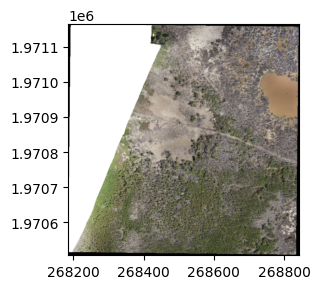

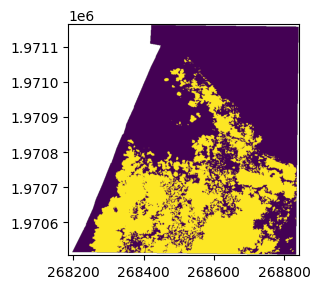

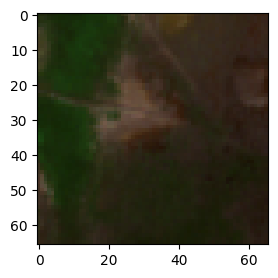

In [10]:
# For visualizing Chunk{...}.tif, labels.tif, and satellite.tif
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

chunk_tif = f'{base_path}/Chunk 1 0-1/Chunk1_0-1.tif'
label_tif = f'{base_path}/Chunk 1 0-1/labels.tif'
satellite_tif = f'{base_path}/Chunk 1 0-1/satellite.tif'

with rasterio.open(chunk_tif) as f:
    arr = f.read()
    print(f"Array shape: {arr.shape}")
    print(f"Count (bands): {f.count}")
    print(f"Dtype: {f.dtypes}")
    print(f"Shape: {f.shape}")
    print(f"Driver: {f.driver}")
    print(f"CRS: {f.crs}")
    print(f"Bounds: {f.bounds}")
    fig, ax = plt.subplots(figsize=(3, 3))
    show(f, ax=ax)
    
with rasterio.open(label_tif) as f:
    arr = f.read()
    print(f"Array shape: {arr.shape}")
    print(f"Count (bands): {f.count}")
    print(f"Dtype: {f.dtypes}")
    print(f"Shape: {f.shape}")
    print(f"Driver: {f.driver}")
    print(f"CRS: {f.crs}")
    print(f"Bounds: {f.bounds}")
    fig, ax = plt.subplots(figsize=(3, 3))
    show(f, ax=ax)

with rasterio.open(satellite_tif) as f:
    arr = f.read()
    print(f"Array shape: {arr.shape}")
    print(f"Count (bands): {f.count}")
    print(f"Dtype: {f.dtypes}")
    print(f"Shape: {f.shape}")
    print(f"Driver: {f.driver}")
    print(f"CRS: {f.crs}")
    print(f"Bounds: {f.bounds}")
    fig, ax = plt.subplots(figsize=(3, 3))
    rgb_arr = f.read([4, 3, 2])
    show(rgb_arr, ax=ax)

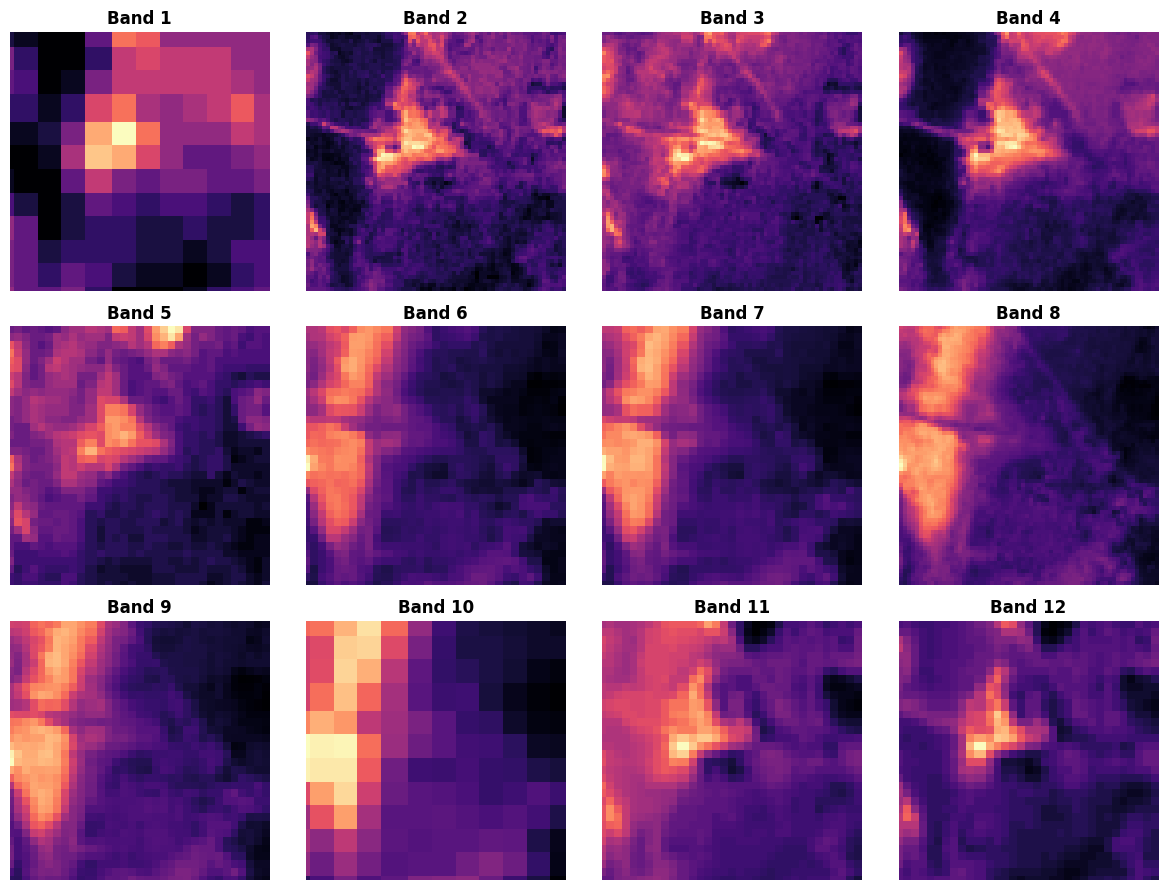

In [13]:
# Visualize all 12 bands of satellite.tif
with rasterio.open(satellite_tif) as f:
    bands = f.indexes
    n_bands = len(bands)
    n_cols = 4
    n_rows = (n_bands + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten()

    for ax, b in zip(axes, bands):
        arr = f.read(b)
        show(arr, ax=ax, cmap="magma", title=f"Band {b}")
        ax.axis('off')

    fig.tight_layout()
    plt.show()

Drone dataset shape=(2, 3, 256, 256)
Label dataset shape=(2, 1, 256, 256)
Satellite dataset shape=(2, 12, 256, 256)


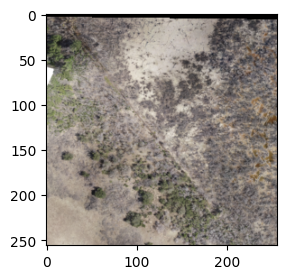

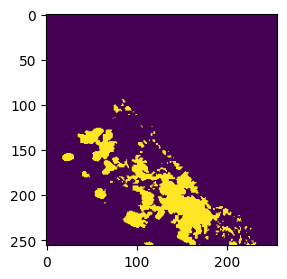

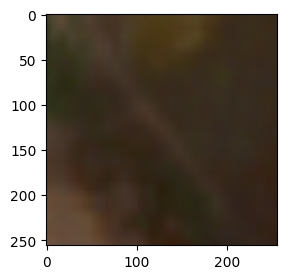

In [11]:
# Visualize dataset tiles
drone_images = np.load(combined_drone_file, mmap_mode='r+')
labels = np.load(combined_label_file, mmap_mode='r+')
satellite_images = np.load(combined_satellite_file, mmap_mode='r+')

print(f"Drone dataset shape={drone_images.shape}")
print(f"Label dataset shape={labels.shape}")
print(f"Satellite dataset shape={satellite_images.shape}")

# Plot individual tile
idx = 0
plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(drone_images[idx], (1, 2, 0)))

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(labels[idx], (1, 2, 0)), cmap='viridis')

plt.figure(figsize=(3, 3))
satellite_rgb = satellite_images[idx][[3, 2, 1], :, :]
plt.imshow(np.transpose(satellite_rgb, (1, 2, 0)))